<a href="https://colab.research.google.com/github/nishanthchaganty/Ciphar10_Deploy/blob/main/ImageClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow tensorflow-gpu openc-python matplotlib


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
!pip list


In [ ]:
%cd data/happy
!ls
!unzip happy.zip



In [ ]:
%cd ../sad
!ls
!unzip sad.zip

In [ ]:
%cd content

/content


In [ ]:
import tensorflow as tf
import os, os.path
import matplotlib.pyplot as plt

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
import cv2
import imghdr # Check file extensions of images

In [ ]:
data_dir = 'data'
image_exts =['jpeg', 'jpg', 'bmp', 'png']

In [ ]:
len(os.listdir(os.path.join(data_dir, 'happy')))

97

In [ ]:
len(os.listdir(os.path.join(data_dir, 'sad')))

74

In [ ]:
# For weeding out smaller images under 10kb for both happy and sad images

In [ ]:

for root, _, files in os.walk("data/"):
    for f in files:
        fullpath = os.path.join(root, f)
        try:
            if os.path.getsize(fullpath) < 10 * 1024:   #set file size in kb
                # print(fullpath)
                os.remove(fullpath)

        except WindowsError:
          print("Error" + fullpath)

In [ ]:
os.listdir(os.path.join(data_dir, image_class))

In [ ]:
# Cleaning images not belonging to expected image extensions

for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir, image_class)):
    image_path = os.path.join(data_dir, image_class, image)
    try:
      img = cv2.imread(image_path)
      tip = imghdr.what(image_path)
      if tip not in image_exts:
        os.remove(image_path)
        print(f'Image not a valid extension {image_path}')
    except:
      print(f'Issue with image: {image_path}')

In [ ]:
!pwd

/content


In [ ]:
from struct import unpack
from tqdm import tqdm
import os


marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}


class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()

    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]
            if len(data)==0:
                break


bads = []

for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir, image_class)):
    image_path = os.path.join(data_dir, image_class, image)
    image = JPEG(image_path)
    try:
      image.decode()
    except:
      bads.append(image_path)


# for name in bads:
#   os.remove(os.join(root_img,name))

In [ ]:
bads

['data/sad/Sadder-not-wiser_AdobeStock_219682170.jpg',
 'data/happy/p24783774_b_v13_ab.jpg']

In [ ]:

for name in bads:
  os.remove(name)

## Load Data

In [ ]:
import numpy as np
!ls
%cd content
!ls

bin	 dev   lib32   mnt			 python-apt  srv    usr
boot	 etc   lib64   NGC-DL-CONTAINER-LICENSE  root	     sys    var
content  home  libx32  opt			 run	     tmp
datalab  lib   media   proc			 sbin	     tools
/content
data  sample_data


In [ ]:
!rmdir .ipynb_checkpoints

rmdir: failed to remove '.ipynb_checkpoints': No such file or directory


In [ ]:
%cd data
!rmdir .ipynb_checkpoints
!ls

/content/data/sad
happy.zip


In [ ]:
%cd ../happy
# !pwd
!rmdir .ipynb_checkpoints
# %cd ../sad
# !rmdir .ipynb_checkpoints
# !ls

/content/data/happy


In [ ]:
# Unzip Data files
# !unzip sad.zip
%cd ../..
# !unzip sad
!pwd

/content
/content


In [ ]:
# Building data pipeline. Create a generator, the images are not loaded into memory at this point.
# We will need to fetch in batches.
data = tf.keras.utils.image_dataset_from_directory('data')

Found 166 files belonging to 2 classes.


In [ ]:
# Access data pipeline. Loop through it
data_iterator = data.as_numpy_iterator()
data_iterator

In [ ]:
batch = data_iterator.next()

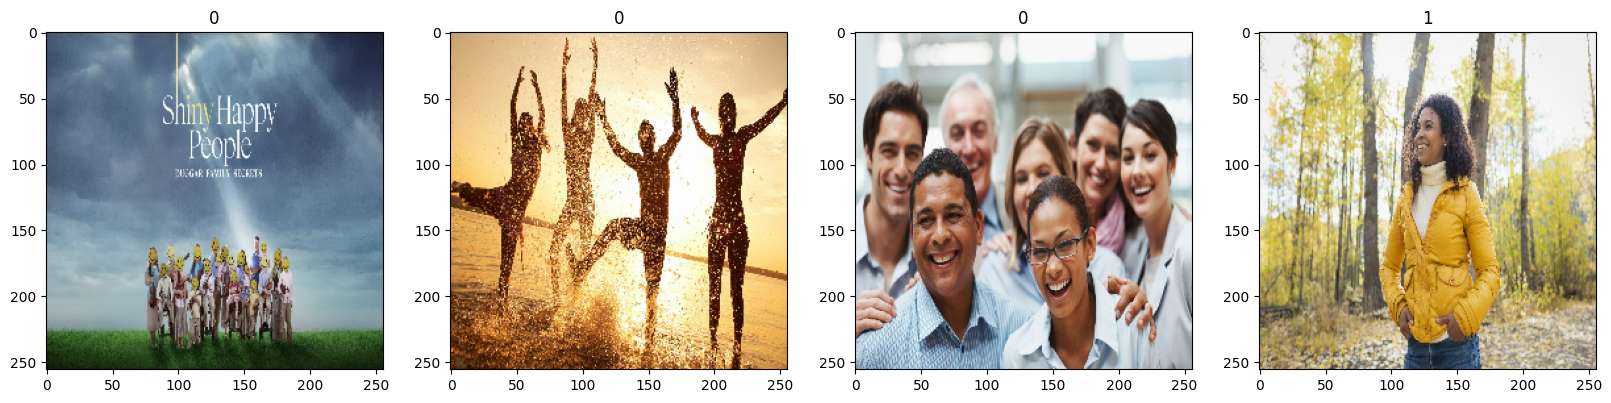

In [ ]:
# Testing Labels

gif, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])


## Image Preprocessing


In [ ]:
data = data.map(lambda image, label: (image/255, label))

In [ ]:
scaled_iterator = data.as_numpy_iterator()


In [ ]:
scaled_batch = scaled_iterator.next()

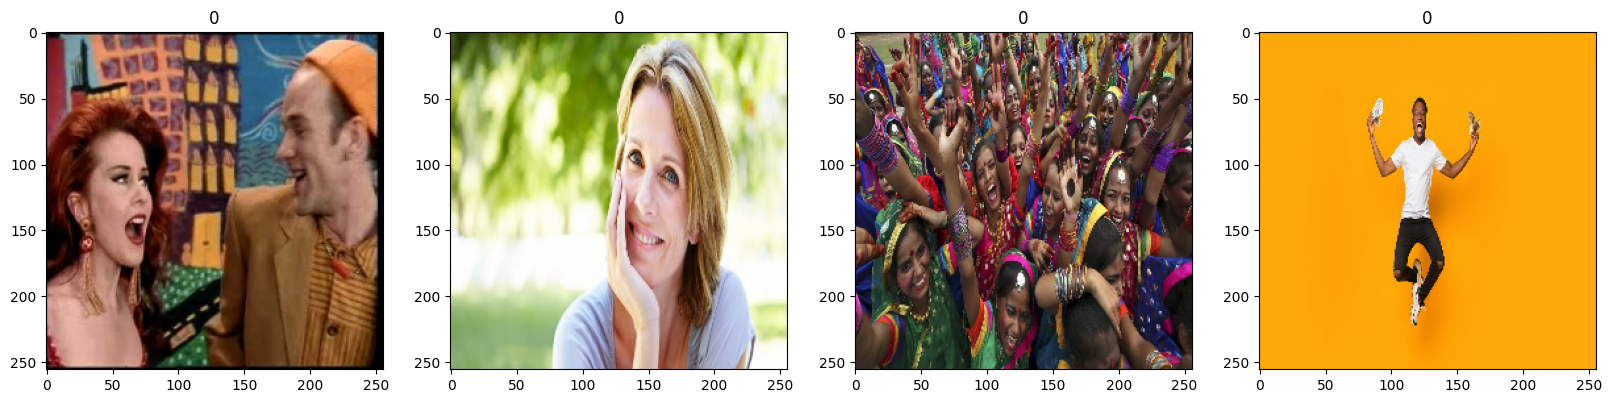

In [ ]:
gif, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(scaled_batch[0][:4]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(scaled_batch[1][idx])


# Split Data

In [ ]:
len(data)

6

In [ ]:
train_size = int(len(data) * .7)
val_size = int(len(data)* .2)
test_size = int(len(data) * .1) + 1

In [ ]:
print(f'Train {train_size}, Val {val_size}, Test {test_size}')

Train 4, Val 1, Test 1


In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size).skip(val_size).take(test_size)

## Build Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
model = Sequential(
    [
        Conv2D(16, (3,3), 1, activation='relu', input_shape=(256, 256, 3)),
        MaxPooling2D(),

        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D(),

        Conv2D(16, (3,3), activation='relu'),
        MaxPooling2D(),

        Flatten(),

        Dense(256, activation='relu'),
        Dense(1, activation='sigmoid')
    ]
)

In [ ]:
model.compile('adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [ ]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)


In [ ]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 [==============================] - 19s 1s/step - loss: 1.0215 - accuracy: 0.6016 - val_loss: 0.6749 - val_accuracy: 0.6562
Epoch 2/20
4/4 [==============================] - 8s 1s/step - loss: 0.6664 - accuracy: 0.6094 - val_loss: 0.5872 - val_accuracy: 0.6250
Epoch 3/20
4/4 [==============================] - 6s 1s/step - loss: 0.5840 - accuracy: 0.7344 - val_loss: 0.4831 - val_accuracy: 0.6875
Epoch 4/20
4/4 [==============================] - 7s 1s/step - loss: 0.5419 - accuracy: 0.6562 - val_loss: 0.4566 - val_accuracy: 0.8125
Epoch 5/20
4/4 [==============================] - 7s 1s/step - loss: 0.4667 - accuracy: 0.7422 - val_loss: 0.3756 - val_accuracy: 0.9688
Epoch 6/20
4/4 [==============================] - 7s 1s/step - loss: 0.3945 - accuracy: 0.8672 - val_loss: 0.2722 - val_accuracy: 0.9375
Epoch 7/20
4/4 [==============================] - 6s 1s/step - loss: 0.3798 - accuracy: 0.8594 - val_loss: 0.2147 - val_accuracy: 0.9688
Epoch 8/20
4/4 [========================

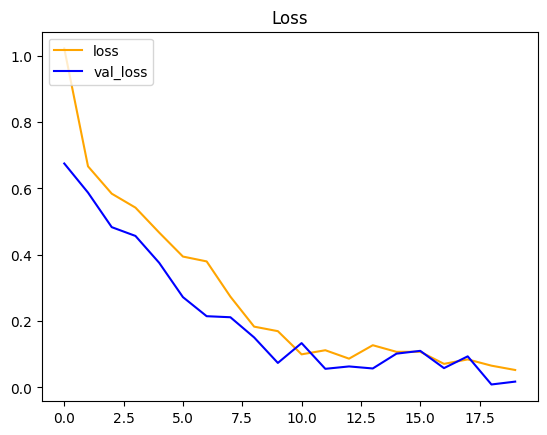

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='orange', label ='loss')
plt.plot(hist.history['val_loss'], color='blue', label='val_loss')
plt.title('Loss')
plt.legend(loc='upper left')
plt.show()

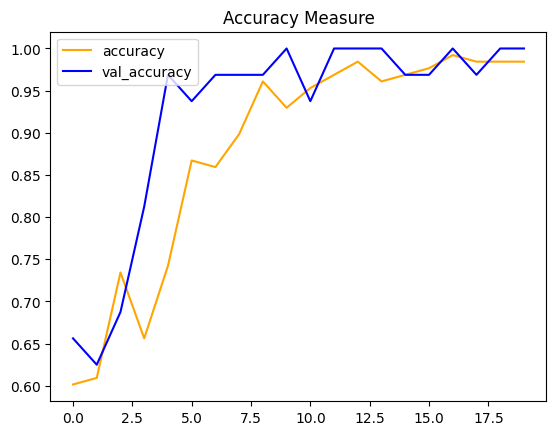

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color ='orange', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='blue', label='val_accuracy')
plt.legend(loc='upper left')
plt.title('Accuracy Measure')
plt.show()

## Evaluate Performance

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

1

In [ ]:
for batch in test.as_numpy_iterator():
  X, y = batch
  yhat = model.predict(X)
  precision.update_state(y, yhat)
  recall.update_state(y, yhat)
  accuracy.update_state(y, yhat)

1/1 [==============================] - 0s 266ms/step


In [ ]:
print(f'Performance Metrics - Precision: {precision.result().numpy()}; Recall: {recall.result().numpy()}; Accuracy: {accuracy.result().numpy()}')

Performance Metrics - Precision: 1.0; Recall: 1.0; Accuracy: 1.0


In [ ]:
# Testing

## Saving the model

In [ ]:
from tensorflow.keras.models import load_model

model.save(os.path.join('models', 'happysadmodels.h5'))

In [ ]:
new_model = load_model(os.path.join('models', 'happysadmodels.h5'))

In [ ]:
new_model.predict(np.expand_dims(resize/255))